# Fashion‑MNIST Classification Project
## Comparison of Convolutional Neural Networks and Random Forests

### Abstract
This project investigates the classification of fashion products using the Fashion‑MNIST dataset. Two machine learning approaches are evaluated: a Convolutional Neural Network (CNN) and a Random Forest classifier. The models are trained and tested on grayscale images belonging to ten fashion categories. Performance is assessed using accuracy, confusion matrices, and precision‑recall metrics. The results demonstrate that the CNN outperforms the Random Forest classifier, particularly for visually similar clothing categories, due to its ability to learn spatial features from image data.

## 1. Introduction

Image classification is a fundamental problem in computer vision, with applications ranging from retail and e‑commerce to medical imaging. In the fashion retail industry, automatic classification of clothing items can improve inventory management, product search, and recommendation systems.

This project focuses on the Fashion‑MNIST dataset, a benchmark dataset introduced by Zalando as a more challenging alternative to the original MNIST dataset. The goal is to evaluate and compare two different classification approaches: a deep learning model (CNN) and a classical machine learning model (Random Forest).

In [97]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D,
    Flatten, Dense, Dropout
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import gzip
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

## 2. Dataset Description

The Fashion‑MNIST dataset consists of 70,000 grayscale images of fashion products, each with a resolution of 28×28 pixels. The dataset contains 10 balanced classes, including T‑shirts, trousers, dresses, footwear, and accessories.

- Training set: 60,000 images
- Test set: 10,000 images
- Number of classes: 10

Each image is associated with a single class label ranging from 0 to 9.

## 3. Data Loading and Preprocessing

The Fashion‑MNIST dataset is provided in IDX format and compressed using GZIP. Custom functions are implemented to read image and label files directly from their binary format.

Preprocessing steps include:
- Normalization of pixel values to the range [0, 1]
- Adding a channel dimension for CNN compatibility
- Reshaping images for Random Forest classification

In [6]:
def load_images(path):
    with gzip.open(path, 'rb') as f:
        data = f.read()

    # IDX image file format
    magic = int.from_bytes(data[0:4], 'big')
    num_images = int.from_bytes(data[4:8], 'big')
    rows = int.from_bytes(data[8:12], 'big')
    cols = int.from_bytes(data[12:16], 'big')

    images = np.frombuffer(data[16:], dtype=np.uint8)
    images = images.reshape(num_images, rows, cols)

    return images

In [30]:
def load_labels(path):
    with gzip.open(path, 'rb') as f:
        data = f.read()

    # IDX image file format
    magic = int.from_bytes(data[0:4], 'big')
    num_images = int.from_bytes(data[4:8], 'big')

    labels = np.frombuffer(data[8:], dtype=np.uint8)

    return labels

In [32]:
x_train = load_images('data/train-images-idx3-ubyte.gz')
y_train = load_labels('data/train-labels-idx1-ubyte.gz')

x_test = load_images('data/t10k-images-idx3-ubyte.gz')
y_test = load_labels('data/t10k-labels-idx1-ubyte.gz')

In [34]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [36]:
# Normalize
x_train = x_train.astype('float32')/255.0
x_test = x_test.astype('float32')/255.0

# Add channel dimension
x_train = x_train[..., np.newaxis]
x_test = x_test[..., np.newaxis]

## 4. Exploratory Data Analysis

To gain an intuitive understanding of the dataset, sample images from the training set are visualized along with their corresponding labels. This step helps confirm correct data loading and highlights the visual similarity between certain clothing categories.

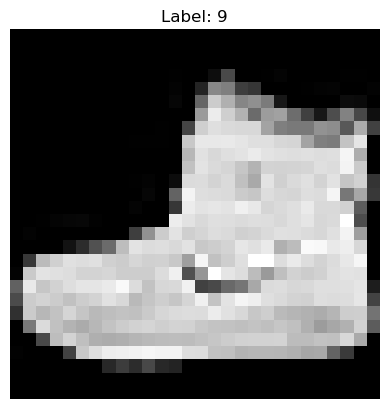

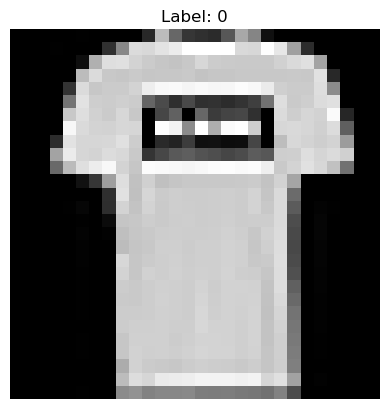

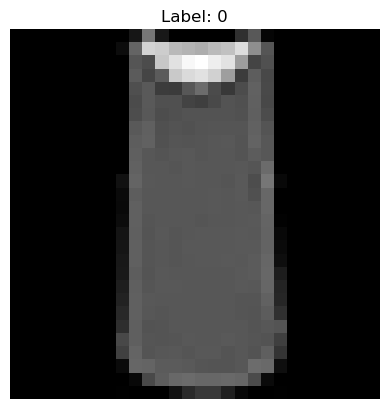

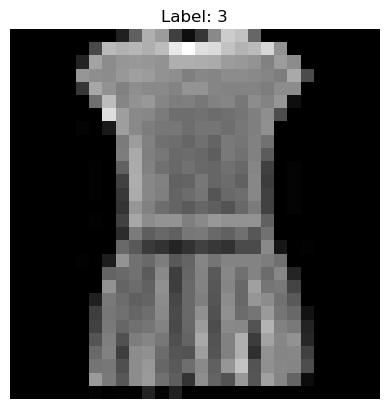

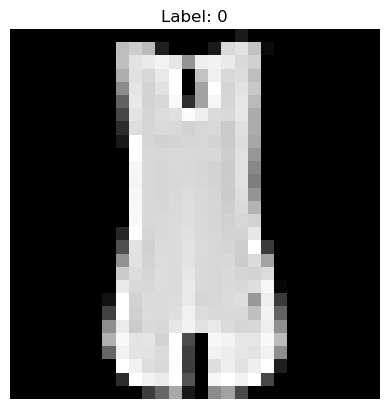

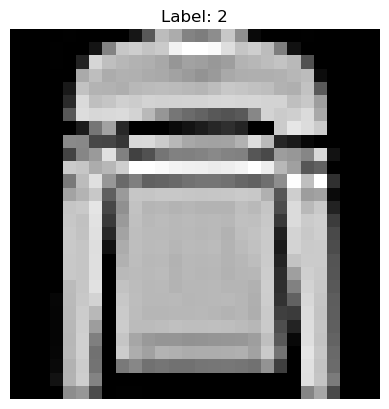

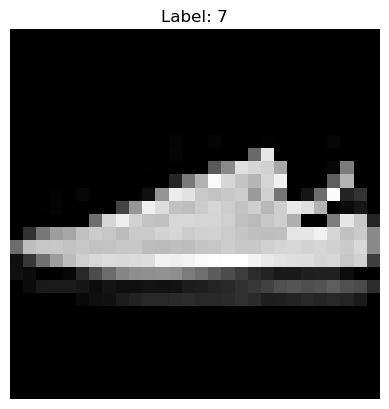

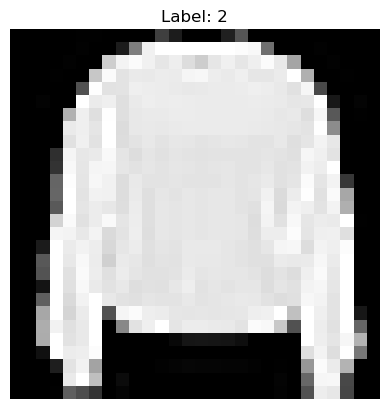

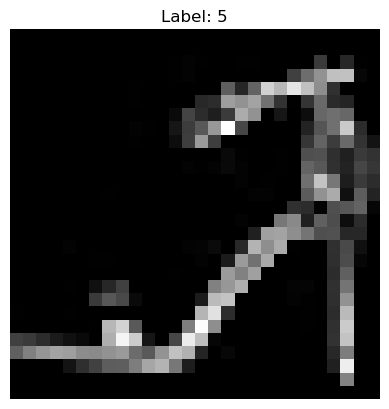

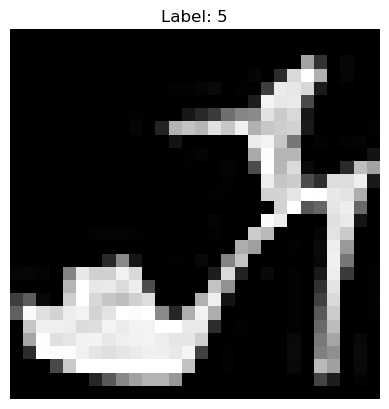

In [128]:
for i in range(10):

    plt.imshow(x_train[i].squeeze(), cmap='gray')
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')

    plt.show()

## 5. Convolutional Neural Network (CNN)

A Convolutional Neural Network is used to exploit the spatial structure of image data. CNNs are particularly well‑suited for image classification tasks due to their ability to learn hierarchical feature representations, such as edges, shapes, and textures.

In [54]:
model = Sequential([
    Input(shape=(28, 28, 1)),
    
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),

    Dense(10, activation='softmax')
])

In [56]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [58]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

### 5.1 CNN Architecture

The CNN architecture consists of two convolutional layers followed by max‑pooling layers, a fully connected dense layer, and a softmax output layer. Dropout is applied to reduce overfitting. The model is trained using the Adam optimizer and sparse categorical cross‑entropy loss.

In [60]:
x_train_sub, x_val, y_train_sub, y_val = train_test_split(
    x_train, y_train,
    test_size=0.1,
    random_state=42,
    stratify=y_train
)

In [62]:
start_time=time.time()

history = model.fit(
    x_train_sub, y_train_sub,
    epochs=10,
    batch_size=128,
    validation_data=(x_val, y_val),
    verbose=1
)

end_time = time.time()

training_time = end_time - start_time

Epoch 1/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 26s 54ms/step - accuracy: 0.6601 - loss: 0.9617 - val_accuracy: 0.8528 - val_loss: 0.4040
Epoch 2/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 23s 55ms/step - accuracy: 0.8317 - loss: 0.4653 - val_accuracy: 0.8740 - val_loss: 0.3346
Epoch 3/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 25s 59ms/step - accuracy: 0.8556 - loss: 0.4037 - val_accuracy: 0.8905 - val_loss: 0.3060
Epoch 4/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 23s 54ms/step - accuracy: 0.8712 - loss: 0.3582 - val_accuracy: 0.8947 - val_loss: 0.2906
Epoch 5/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 41s 53ms/step - accuracy: 0.8825 - loss: 0.3309 - val_accuracy: 0.9012 - val_loss: 0.2698
Epoch 6/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 23s 55ms/step - accuracy: 0.8900 - loss: 0.3082 - val_accuracy: 0.9040 - val_loss: 0.2606
Epoch 7/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 23s 53ms/step - accuracy: 0.8934 - loss: 0.2941 - val_accuracy: 0.9082 - val_loss: 0.2456
Epoch 8/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 23s 53ms/step - accuracy: 0.9004 - loss: 0.2716 - 

In [63]:
print(f"CNN training time:\n{training_time:.2f} seconds.")

Training time:
253.13 seconds.


<Figure size 1200x400 with 0 Axes>

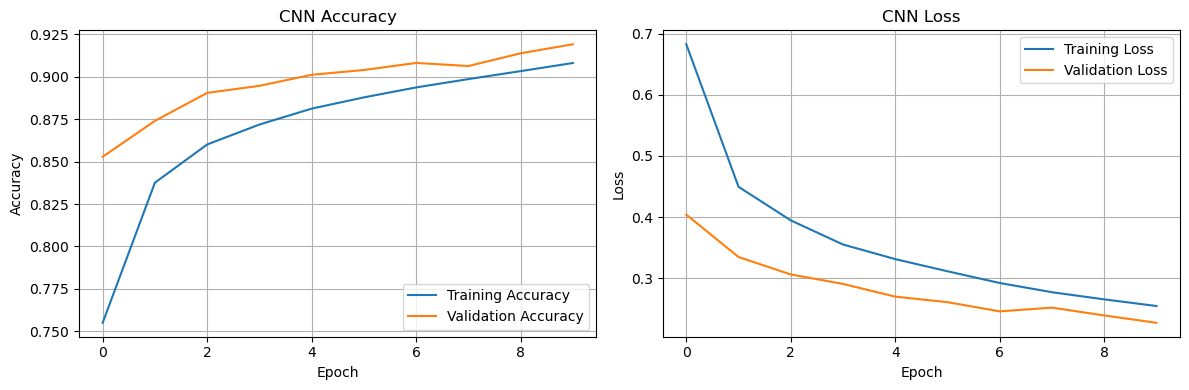

In [66]:
plt.figure(figsize=(12, 4))

plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('CNN Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('CNN Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### 5.2 CNN Training Analysis

Training and validation curves show a steady increase in accuracy and a corresponding decrease in loss. The close alignment between training and validation performance indicates good generalization and minimal overfitting.

In [68]:
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)

print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")

Test loss: 0.2613
Test accuracy: 0.9065


In [70]:
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


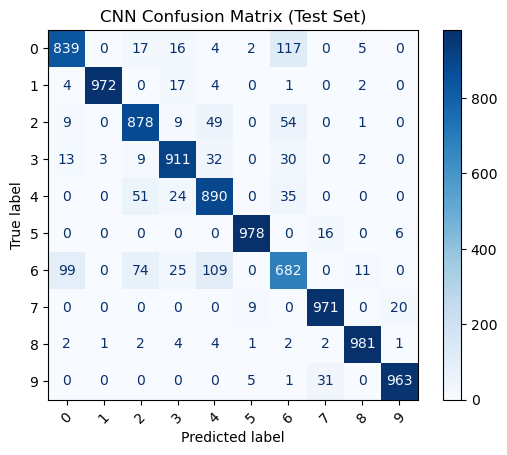

In [76]:
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title('CNN Confusion Matrix (Test Set)')
plt.show()

In [82]:
report = classification_report(
    y_test,
    y_pred,
    output_dict=True,
    target_names=[
        'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
    ]
)

df_report = pd.DataFrame(report).transpose()
df_report

,precision,recall,f1-score,support
T-shirt/top,0.868530,0.8390,0.853510,1000.0000
Trouser,0.995902,0.9720,0.983806,1000.0000
Pullover,0.851600,0.8780,0.864599,1000.0000
Dress,0.905567,0.9110,0.908275,1000.0000
Coat,0.815018,0.8900,0.850860,1000.0000
Sandal,0.982915,0.9780,0.980451,1000.0000
Shirt,0.739696,0.6820,0.709677,1000.0000
Sneaker,0.951961,0.9710,0.961386,1000.0000
Bag,0.979042,0.9810,0.980020,1000.0000
Ankle boot,0.972727,0.9630,0.967839,1000.0000


### 5.3 CNN Evaluation

The CNN achieves strong performance on the test set, particularly for footwear and accessory categories. However, lower performance is observed for visually similar upper‑body garments such as shirts and T‑shirts, which are frequently confused due to overlapping shapes and textures.

## 6. Random Forest Classifier

To provide a baseline comparison, a Random Forest classifier is trained on the same dataset. Since Random Forests do not inherently handle image data, each image is flattened into a one‑dimensional feature vector.

In [84]:
# Flatten 28x28 images into 784‑dim vectors
x_train_rf = x_train.reshape(x_train.shape[0], -1)
x_test_rf = x_test.reshape(x_test.shape[0], -1)

In [92]:
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    n_jobs=1,
    random_state=42
)

In [94]:
start_time = time.time()

rf.fit(x_train_rf, y_train)

end_time = time.time()

training_time_rf = end_time - start_time

In [96]:
print(f"Random Forest training time:\n{training_time_rf:.2f} seconds.")

Random Forest training time:
440.75 seconds.


In [98]:
y_pred_rf = rf.predict(x_test_rf)

accuracy_rf = accuracy_score(y_test, y_pred_rf)

print(f"Random Forest accuracy score:\n{accuracy_rf}")

Random Forest accuracy score:
0.8779


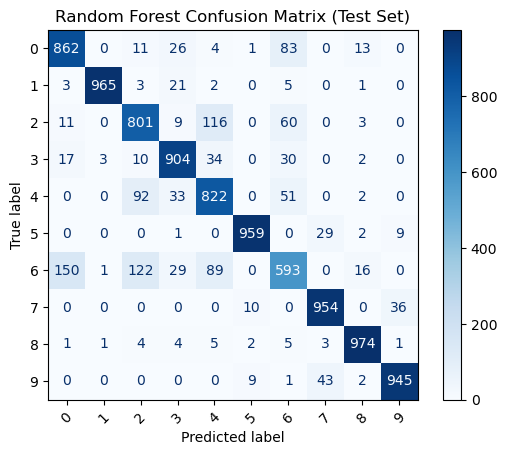

In [105]:
cm_rf = confusion_matrix(y_test, y_pred_rf)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Random Forest Confusion Matrix (Test Set)")
plt.show()

In [107]:
report_rf = classification_report(
    y_test,
    y_pred_rf,
    output_dict=True,
    target_names=[
        'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
    ]
)

df_report_rf = pd.DataFrame(report_rf).transpose()
df_report_rf

,precision,recall,f1-score,support
T-shirt/top,0.825670,0.8620,0.843444,1000.0000
Trouser,0.994845,0.9650,0.979695,1000.0000
Pullover,0.767977,0.8010,0.784141,1000.0000
Dress,0.880234,0.9040,0.891959,1000.0000
Coat,0.766791,0.8220,0.793436,1000.0000
Sandal,0.977574,0.9590,0.968198,1000.0000
Shirt,0.716184,0.5930,0.648796,1000.0000
Sneaker,0.927114,0.9540,0.940365,1000.0000
Bag,0.959606,0.9740,0.966749,1000.0000
Ankle boot,0.953582,0.9450,0.949272,1000.0000


### 6.1 Random Forest Evaluation

The Random Forest classifier achieves reasonable accuracy but performs worse than the CNN across most classes. The lack of spatial feature learning results in increased confusion between visually similar categories, particularly upper‑body clothing.

## 7. Model Comparison

A direct comparison between the CNN and Random Forest classifiers highlights the advantages of deep learning for image‑based tasks. While the Random Forest provides a strong classical baseline, the CNN consistently achieves higher accuracy, better recall for difficult classes, and shorter training time in this implementation.

## 8. Conclusion and Recommendation

This project compared a Convolutional Neural Network and a Random Forest classifier for fashion image classification. Experimental results show that the CNN outperforms the Random Forest in terms of accuracy, class‑wise recall, and robustness to visually similar categories.

Based on these findings, the CNN is recommended for production use in fashion product classification systems, as it better captures spatial information and scales more effectively to complex visual tasks.